<h1><center>Fake Audio Detection</center></h1>

## Importing all the necessary libraries

In [23]:
import numpy as np
import pandas as pd 
import os 
import glob
import soundfile as sf
import scipy.io.wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
import pathlib
import shutil
import random

from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import time
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Set Path value to location where AVS_DATA is downloaded

In [20]:
os.getcwd()

Path = 'C:/Users/Ashish/Downloads' #change '\' to '/' 

os.chdir(Path + '/AVS_Data') #changing current directory to Path/AVS_Data

### Accessing the text file containing information on the audio type and using to it extract real and spoof audio.

In [ ]:
data = pd.read_csv('Audio.txt', sep=" ", header=None)
data.columns = ["a", "FileName", "c", "FakeType", 'Class']

In [ ]:
data.to_csv('AudioData.csv')

### Creating a new folder to store real audio files (files termed as bonafide)

In [ ]:
data1 = data[data['FakeType']== '-']
data1.shape

In [ ]:
pathlib.Path(f'AudioData/Real').mkdir(parents=True, exist_ok=True)
realaudio = data1['FileName']
for file in realaudio:
    file_name = os.path.join('flac/',file +'.flac')
    if os.path.isfile(file_name):
        shutil.copy(file_name, 'AudioData/Real')

### Creating a folder for tts fake audio

In [ ]:
data2 = data[data['FakeType'].isin(['A01','A02','A04', 'A07','A11'])] 
data2.shape

In [ ]:
pathlib.Path(f'AudioData/Spoof_TTS').mkdir(parents=True, exist_ok=True)
ttsaudio = data2['FileName']
for file in ttsaudio:
    file_name = os.path.join('flac/',file +'.flac')
    if os.path.isfile(file_name):
        shutil.copy(file_name, 'AudioData/Spoof_TTS')

### Creating a folder for VC fake audio

In [ ]:
data3 = data[data['FakeType'].isin(['A05','A06','A17','A18', 'A19'])] 
data3.shape

In [ ]:
pathlib.Path(f'AudioData/Spoof_VC').mkdir(parents=True, exist_ok=True)
vcaudio = data3['FileName']
for file in vcaudio:
    file_name = os.path.join('flac/',file +'.flac')
    if os.path.isfile(file_name):
        shutil.copy(file_name, 'AudioData/Spoof_VC')

## Creating spectogram  and saving the generated images into Image Data folder

### Spectogram of Real Audio data 

In [ ]:
pathlib.Path(f'ImageData/Real').mkdir(parents=True, exist_ok=True)
for filename in os.listdir(f'AudioData/Real'):
    y, sr = sf.read(f'AudioData/Real/{filename}')
    plt.specgram(y,Fs=sr);
    plt.axis('off');
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
    plt.savefig(f'ImageData/Real/{filename[0:-5]}.png')
    plt.clf()

### Spectogram of TTS Fake Audio data 

In [ ]:
pathlib.Path(f'ImageData/Spoof_TTS').mkdir(parents=True, exist_ok=True)
for filename in os.listdir(f'AudioData/Spoof_TTS'):
    y, sr = sf.read(f'AudioData/Spoof_TTS/{filename}')
    plt.specgram(y,Fs=sr);
    plt.axis('off');
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
    plt.savefig(f'ImageData/Spoof_TTS/{filename[0:-5]}.png')
    plt.clf()

### Spectogram of VC Fake Audio data 

In [2]:
pathlib.Path(f'ImageData/Spoof_VC').mkdir(parents=True, exist_ok=True)
for filename in os.listdir(f'AudioData/Spoof_VC'):
    y, sr = sf.read(f'AudioData/Spoof_VC/{filename}')
    plt.specgram(y,Fs=sr);
    plt.axis('off');
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0);
    plt.savefig(f'ImageData/Spoof_VC/{filename[0:-5]}.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

### Copying all Spectograms into one folder (Spectograms)

In [28]:
pathlib.Path(f'Spectograms').mkdir(parents=True, exist_ok=True)
for f in ('Real/', 'Spoof_TTS/', 'Spoof_VC/'):
    for jpgfile in glob.iglob(os.path.join('ImageData/'+f, "*.png")):
        shutil.copy(jpgfile, 'Spectograms')

# Model Building

## Image Parameters 

In [2]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Creating a dataframe all the images and assigning them labels accordingly

In [3]:
# Read the real and spoof spectrogram images from directory
filename1 = os.listdir("ImageData/Real/")
filename2 = os.listdir("ImageData/Spoof_TTS/")
filename3 = os.listdir("ImageData/Spoof_VC/")
category1 = []
category2 = []
category3 = []

In [4]:
# Check the length of the list
print(len(filename1))
print(len(filename2))
print(len(filename3))

2580
11400
7600


In [5]:
# Shuffle the data randomly
random.shuffle(filename1)
random.shuffle(filename2)
random.shuffle(filename3)

In [6]:
# Get filename and assign label '0' for real images and stored in dataframe
for filename in filename1:
    category1.append(0)    
df1 = pd.DataFrame({ 'filename': filename1,'category': category1 })    

# Get filename and assign label '1' for TTS fake images and stored in dataframe
for filename in filename2:
    category2.append(1)    
df2 = pd.DataFrame({ 'filename': filename2, 'category': category2 })

# Get filename and assign label '2' for VC fake images and stored in dataframe
for filename in filename3:
    category3.append(2)    
df3 = pd.DataFrame({ 'filename': filename3, 'category': category3 })

In [7]:
# Combined the dataframes
frames = [df1, df2, df3]
df = pd.concat(frames)

In [8]:
# Dataframe structure
df.head(4)

,filename,category
0,LA_T_2127844.png,0
1,LA_T_3913974.png,0
2,LA_T_2528047.png,0
3,LA_T_4451463.png,0


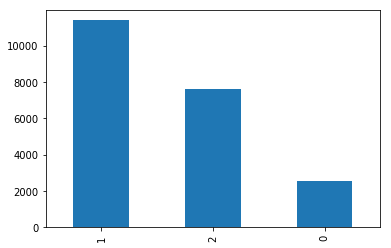

In [9]:
df['category'].value_counts().plot.bar()

## Building the CNN model

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [13]:
# To prevent over fitting , stop the learning after 10 epochs and reduce learning rate after two steps
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
# Saved callbacks parameters
callbacks = [earlystop, learning_rate_reduction]

In [15]:
# Replace output label data
df["category"] = df["category"].replace({0: 'Real', 1: 'TTS_Spoof', 2: 'VC_Spoof'}) 

In [16]:
# Data splitting into train and test data and keep this test data aside for model prediction
trainData_df, testData_df = train_test_split(df, test_size=0.20, random_state=42)
trainData_df = trainData_df.reset_index(drop=True)
testData_df = testData_df.reset_index(drop=True)

In [17]:
# Again split the above train data into new train dataset (used to train the model ) 
# and validation set
train_df, validate_df = train_test_split(trainData_df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

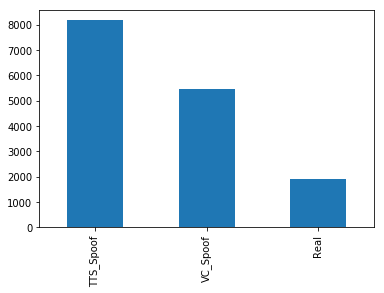

In [18]:
train_df['category'].value_counts().plot.bar()

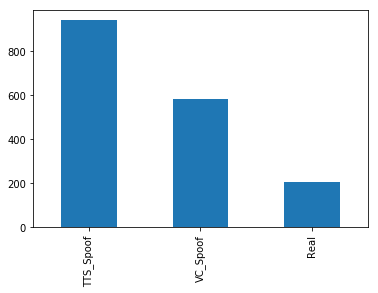

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = testData_df.shape[0]
batch_size=15

In [21]:
# generic image data generator 
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [22]:
# Train image data generator
# Create new train folder directory which should have both the images real and fake combined.
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Spectograms", 
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 15537 validated image filenames belonging to 3 classes.


In [23]:
# Validation image data generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1727 validated image filenames belonging to 3 classes.


# Model Fit

In [25]:
epochs=5 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch= 100, #total_train//batch_size, 
    #[Originally steps per epoch should be total_train//batch_size but for now lets try with 50]
    callbacks=callbacks   
)

Epoch 1/50
100/100 [==============================] - 146s 1s/step - loss: 0.5603 - accuracy: 0.7687 - val_loss: 0.2290 - val_accuracy: 0.7983
Epoch 2/50


C:\Users\Ashish\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


100/100 [==============================] - 146s 1s/step - loss: 0.5835 - accuracy: 0.7620 - val_loss: 1.4175 - val_accuracy: 0.3160
Epoch 3/50
100/100 [==============================] - 146s 1s/step - loss: 0.5154 - accuracy: 0.7967 - val_loss: 7.1957 - val_accuracy: 0.5415
Epoch 4/50
100/100 [==============================] - 146s 1s/step - loss: 0.5833 - accuracy: 0.7507 - val_loss: 0.5735 - val_accuracy: 0.6028
Epoch 5/50
100/100 [==============================] - 146s 1s/step - loss: 0.5650 - accuracy: 0.7673 - val_loss: 0.3311 - val_accuracy: 0.8189
Epoch 6/50
100/100 [==============================] - 145s 1s/step - loss: 0.5591 - accuracy: 0.7802 - val_loss: 0.6956 - val_accuracy: 0.7512
Epoch 7/50
100/100 [==============================] - 147s 1s/step - loss: 0.5943 - accuracy: 0.7587 - val_loss: 0.3637 - val_accuracy: 0.7634
Epoch 8/50
100/100 [==============================] - 148s 1s/step - loss: 0.5168 - accuracy: 0.7847 - val_loss: 1.8913 - val_accuracy: 0.5567
Epoch 9/50

# Visualization

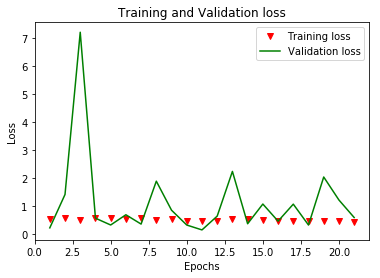

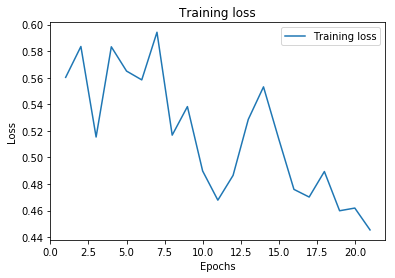

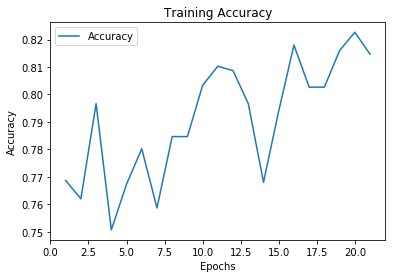

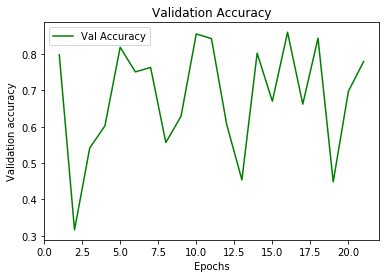

In [51]:
def visualize(loss, val_loss):
    '''
    Plots a graph for training and validation loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,'rv',label='Training loss')
    plt.plot(epochs,val_loss,'g',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize1(loss):
    '''
    Plots a graph for training loss and accuracy
    '''
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs,loss,label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize2(accuracy):
    '''
    Plots a graph for accuracy
    '''
    epochs = range(1,len(accuracy)+1)
    plt.figure()
    plt.plot(epochs,accuracy,label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def visualize3(val_accuracy):
    '''
    Plots a graph for val accuracy
    '''
    epochs = range(1,len(val_accuracy)+1)
    plt.figure()
    plt.plot(epochs,val_accuracy,'g', label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation accuracy')
    plt.legend()
    plt.show()

visualize(history.history['loss'], history.history['val_loss'])
visualize1(history.history['loss'])
visualize2(history.history['accuracy'])
visualize3(history.history['val_accuracy'])

In [29]:
# Used above created test dataset for test image data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    testData_df, 
    "Spectograms",
    x_col='filename',
    y_col='category',
    seed=30,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4316 validated image filenames belonging to 3 classes.


# Model Prediction

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(total_test/batch_size), verbose= 1)

288/288 [==============================] - 91s 316ms/step


In [31]:
testData_df['Pred_category'] = np.argmax(predict, axis=1)

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
testData_df['Pred_category'] = testData_df['Pred_category'].replace(label_map)

<Figure size 432x288 with 0 Axes>

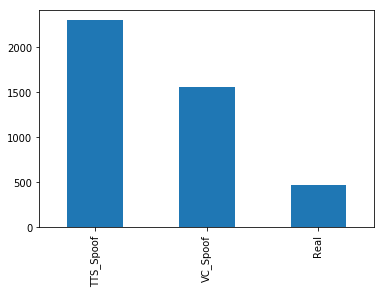

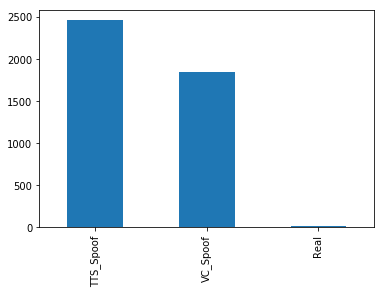

In [69]:
plt.figure()
plt.subplots(1,1)
testData_df['category'].value_counts().plot.bar()
plt.subplots(1,1)
testData_df['Pred_category'].value_counts().plot.bar()
plt.show()

In [34]:
testData_df['category'].value_counts()

TTS_Spoof    2295
VC_Spoof     1552
Real          469
Name: category, dtype: int64

In [35]:
testData_df['Pred_category'].value_counts()

TTS_Spoof    2456
VC_Spoof     1844
Real           16
Name: Pred_category, dtype: int64

In [ ]:
print('Prediction Accuracy =',metrics.accuracy_score(testData_df['category'], testData_df['Pred_category']))